In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np

csv_path = 'TorqueData_noFriction_NL_NG.xlsx'

torqueData = pd.read_excel(csv_path)

torque = torqueData['Torque']

def torque_to_X_y(torqueData, window_size = 5):
    torque_as_np = torqueData.to_numpy()
    X = []
    y = []
    for i in range(len(torque_as_np)-window_size):
        row = [[a] for a in torque_as_np[i:i+5]]
        X.append(row)
        label = torque_as_np[i+5]
        y.append(label)
    return np.array(X),np.array(y)

In [2]:
WINDOW_SIZE = 5
X,y = torque_to_X_y(torque,WINDOW_SIZE)
X = X.reshape(X.shape[0], 5, 1)
X_train, y_train = X[:1300], y[:1300]
X_val, y_val = X[1300:1600], y[1300:1600]
X_test, y_test = X[1600:2300], y[1600:2300]

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((5,1)))
model1.add(LSTM(64,input_shape=(X.shape[1], X.shape[2]),unroll=True))
#model1.add(Dense(8,'relu'))
#model1.add(Dense(1,'linear'))
model1.summary()

C:\Users\malth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,896 (66.00 KB)

 Trainable params: 16,896 (66.00 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
cp = ModelCheckpoint('model1.keras',save_best_only=True)
model1.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=0.0001),metrics=[RootMeanSquaredError()])
model1.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=10,batch_size = 1,callbacks=[cp])

Epoch 1/10
1300/1300 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4.9506e-09 - root_mean_squared_error: 7.0115e-05 - val_loss: 3.8353e-09 - val_root_mean_squared_error: 6.1930e-05
Epoch 2/10
1300/1300 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 5.2081e-09 - root_mean_squared_error: 7.1967e-05 - val_loss: 1.3630e-08 - val_root_mean_squared_error: 1.1675e-04
Epoch 3/10
1300/1300 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.1201e-09 - root_mean_squared_error: 7.0995e-05 - val_loss: 8.2454e-09 - val_root_mean_squared_error: 9.0804e-05
Epoch 4/10
1300/1300 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 5.6265e-09 - root_mean_squared_error: 7.4678e-05 - val_loss: 3.7080e-09 - val_root_mean_squared_error: 6.0893e-05
Epoch 5/10
1300/1300 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6.0115e-09 - root_mean_squared_error: 7.7056e-05 - val_loss: 3.6821e-09 - val_root_mean_squared_error: 6.0680e-05
Epoch 6/10
1300/1300 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.0677e-09 - root_mean_squared_error: 7.1029e-05 - val_los

In [8]:
from tensorflow.keras.models import load_model
model1 = load_model('model1.keras')
def forecast_lstm(model, X, n_batch):
    # Reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, len(X), 1)  # Ensure there's one feature per timestep
    # Make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # Convert to array
    return [x for x in forecast[0, :]]

# Evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # Make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # Store the forecast
        forecasts.append(forecast)
    return forecasts

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

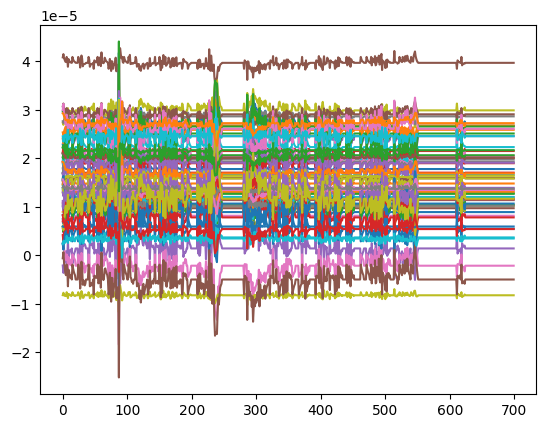

In [14]:
import matplotlib.pyplot as plt
n_lag = 5
n_seq = 1
n_epochs = 20  # Number of epochs for training
n_batch = 1  # Batch size
n_neurons = 2  # Number of neurons in the LSTM layer
train_predictions = make_forecasts(model1, n_batch, X_train, X_test, n_lag, n_seq)
plt.plot(train_predictions)